# a gentle exploration tour through the Monad-Bayes library

https://github.com/adscib/monad-bayes

In [55]:
:e OverloadedStrings

import qualified Graphics.Vega.VegaLite as VL
import Graphics.Vega.VegaLite hiding (filter)
import IHaskell.Display.Hvega (vlShow)
import Data.Aeson (ToJSON(toJSON), Value)
import Data.Aeson (encode)
import qualified Data.ByteString.Lazy.Char8 as BL

import Control.Monad (liftM2)
import Control.Monad.IO.Class (liftIO)
import Control.Monad.Bayes.Class
import Control.Monad.Bayes.Sampler
import Control.Monad.Bayes.Sequential
import Control.Monad.Bayes.Population
import Control.Monad.Bayes.Inference.SMC

barPlot :: [Int] -> VegaLite
barPlot dataSamples = 
  let desc = description "Probability Games"
      dat = dataFromColumns []
          . dataColumn "Result" (Numbers (map fromIntegral dataSamples))
      conf = configure
        . configuration (Axis [ DomainWidth 1 ])
        . configuration (BarStyle [ MContinuousBandSize 20 ])
        . configuration (SelectionStyle [ ( Single, [ On "dblclick" ] ) ])
      barOpts = [MOpacity 0.4, MColor "blue"]
      enc = encoding
            . position X [PName "Result", PmType Quantitative, PAxis [AxGrid True, AxTitle "Toss Value"]]
            . position Y [PAggregate Count, PmType Quantitative, PAxis [AxGrid False]]
  in toVegaLite [desc, width 600, height 200, dat [], conf [], mark Bar barOpts, enc []]

## Modelling Dice

In [48]:
-- A toy model for dice rolling from http://dl.acm.org/citation.cfm?id=2804317
-- Exact results can be obtained using Dist monad

-- | A toss of a six-sided die.
die :: MonadSample m => m Int
die = uniformD [1..6]

-- | A sum of outcomes of n independent tosses of six-sided dice.
dice :: MonadSample m => Int -> m Int
dice 1 = die
dice n = liftM2 (+) die (dice (n-1))

-- | Toss of two dice where the output is greater than 4.
dice_hard :: MonadInfer m => m Int
dice_hard = do
  result <- dice 2
  condition (result > 4)
  return result

In [49]:
takeFromModel :: Int -> Sequential (Population SamplerIO) a -> IO [a]
takeFromModel nsamples inModel = sampleIOfixed $ do
    res <- runPopulation $ smcMultinomial 0 nsamples inModel
    return $ map fst res

In [50]:
takeFromModel 20 dice_hard

[3,7,10,6,7,9,5,7,6,8,11,11,4,7,10,11,8,8,6,7]

## Two alternating distributions

In [51]:
prior :: MonadSample m => m Double
prior = return 0.2

modelFalse :: MonadSample m => m Int
modelFalse = uniformD ([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] :: [Int])

modelTrue :: MonadSample m => m Int
modelTrue = do
  x <- bernoulli 0.5
  y <- uniformD (if x then [1, 2] else [11, 12] :: [Int])
  return y

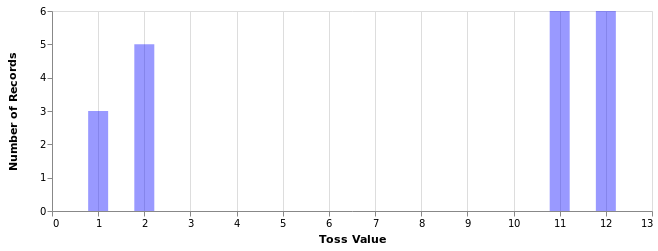

In [54]:
samples <- sampleToList 20 modelTrue
vlShow $ barPlot samples